
# Transforms v2: End-to-end object detection/segmentation example

<div class="alert alert-info"><h4>Note</h4><p>Try on [Colab](https://colab.research.google.com/github/pytorch/vision/blob/gh-pages/main/_generated_ipynb_notebooks/plot_transforms_e2e.ipynb)
    or `go to the end <sphx_glr_download_auto_examples_transforms_plot_transforms_e2e.py>` to download the full example code.</p></div>

Object detection and segmentation tasks are natively supported:
``torchvision.transforms.v2`` enables jointly transforming images, videos,
bounding boxes, and masks.

This example showcases an end-to-end instance segmentation training case using
Torchvision utils from ``torchvision.datasets``, ``torchvision.models`` and
``torchvision.transforms.v2``. Everything covered here can be applied similarly
to object detection or semantic segmentation tasks.


In [1]:
import os

import pathlib

import torch
import torch.utils.data

from torchvision import models, datasets, tv_tensors
from torchvision.transforms import v2

from typing import Any, Callable, List, Optional, Tuple, Union

torch.manual_seed(0)

# This loads fake data for illustration purposes of this example. In practice, you'll have
# to replace this with the proper data.
# If you're trying to run that on Colab, you can download the assets and the
# helpers from https://github.com/pytorch/vision/tree/main/gallery/
ROOT = pathlib.Path("../assets") / "coco"
IMAGES_PATH = str(ROOT / "images")
ANNOTATIONS_PATH = str(ROOT / "instances.json")

DATASET_DIR =  "c:/Users/Rohan/datasets/coco" # "data/coco"
TRAIN_DIR = DATASET_DIR + "/images/train2017"
TRAIN_ANNOT = DATASET_DIR + "/annotations/instances_train2017.json"

from segmentation.helpers import plot

## Dataset preparation

We start off by loading the :class:`~torchvision.datasets.CocoDetection` dataset to have a look at what it currently
returns.



In [3]:
class CustomCoco(datasets.CocoDetection):
    def __init__(self,
                 root,
                 annFile,
                 transform=None,
                 target_transform=None,
                 transforms=None) -> None:
        # from pycocotools.coco import COCO
        super().__init__(root= root, annFile= annFile, transform= transform, target_transform= target_transform, transforms= transforms)

        self.no_annots = open("no_annots.txt").read().splitlines() # All ids with no annotations
        self.ids = sorted([id for id in self.coco.imgs.keys() if str(id) not in self.no_annots])
        
        # You can get the above list by applying your filtering logic to
        # this list :list(self.coco.imgs.keys()) So this would only be have
        # to be done only once.
        # Save it to a text file. This file will now contain the names of
        # images that match your criteria
        # Load that file contents in the init function into self.ids
        # the length would automatically be correct

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        if not isinstance(index, int):
            raise ValueError(f"Index must be of type integer, got {type(index)} instead.")

        id = self.ids[index] # ids should be less
        image = self._load_image(id)
        target = self._load_target(id)

        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target
    
    def __len__(self) -> int:
        return len(self.ids)

In [ ]:
dataset = CustomCoco(TRAIN_DIR, TRAIN_ANNOT)

sample = dataset[0]
img, target = sample
print(f"{type(img) = }\n{type(target) = }\n{type(target[0]) = }\n{target[0].keys() = }")

Torchvision datasets preserve the data structure and types as it was intended
by the datasets authors. So by default, the output structure may not always be
compatible with the models or the transforms.

To overcome that, we can use the
:func:`~torchvision.datasets.wrap_dataset_for_transforms_v2` function. For
:class:`~torchvision.datasets.CocoDetection`, this changes the target
structure to a single dictionary of lists:



In [12]:
dataset = datasets.wrap_dataset_for_transforms_v2(dataset, target_keys=("boxes", "labels", "masks"))

sample = dataset[0]
img, target = sample
print(f"{type(img) = }\n{type(target) = }\n{target.keys() = }")
print(f"{type(target['boxes']) = }\n{type(target['labels']) = }\n{type(target['masks']) = }")

type(img) = <class 'PIL.Image.Image'>
type(target) = <class 'dict'>
target.keys() = dict_keys(['boxes', 'masks', 'labels'])
type(target['boxes']) = <class 'torchvision.tv_tensors._bounding_boxes.BoundingBoxes'>
type(target['labels']) = <class 'torch.Tensor'>
type(target['masks']) = <class 'torchvision.tv_tensors._mask.Mask'>


We used the ``target_keys`` parameter to specify the kind of output we're
interested in. Our dataset now returns a target which is dict where the values
are `TVTensors <what_are_tv_tensors>` (all are :class:`torch.Tensor`
subclasses). We're dropped all unncessary keys from the previous output, but
if you need any of the original keys e.g. "image_id", you can still ask for
it.

<div class="alert alert-info"><h4>Note</h4><p>If you just want to do detection, you don't need and shouldn't pass
    "masks" in ``target_keys``: if masks are present in the sample, they will
    be transformed, slowing down your transformations unnecessarily.</p></div>

As baseline, let's have a look at a sample without transformations:



(<PIL.Image.Image image mode=RGB size=640x424>,
 {'boxes': BoundingBoxes([[5.5620e+01, 1.8601e+02, 1.4133e+02, 2.2157e+02],
                 [5.1432e+02, 1.7977e+02, 5.4932e+02, 1.9798e+02],
                 [4.7851e+02, 1.7580e+02, 5.0943e+02, 1.9851e+02],
                 [2.8600e+00, 4.8000e-01, 6.4000e+02, 4.1875e+02],
                 [5.4407e+02, 1.7231e+02, 5.5219e+02, 1.7848e+02],
                 [5.3366e+02, 1.7151e+02, 5.4111e+02, 1.7811e+02],
                 [4.2020e+02, 8.5510e+01, 6.4000e+02, 1.4160e+02],
                 [5.0375e+02, 1.6988e+02, 5.1933e+02, 1.7758e+02]], format=BoundingBoxFormat.XYXY, canvas_size=(424, 640)),
  'masks': Mask([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],
  
        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
        

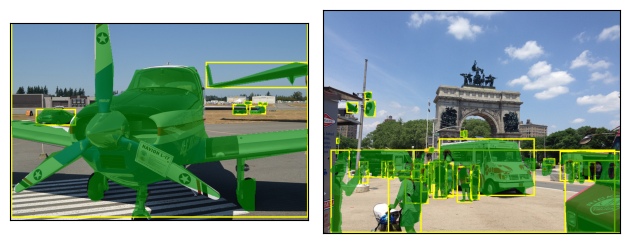

In [ ]:
plot([dataset[41], dataset[42]])

## Transforms

Let's now define our pre-processing transforms. All the transforms know how
to handle images, bounding boxes and masks when relevant.

Transforms are typically passed as the ``transforms`` parameter of the
dataset so that they can leverage multi-processing from the
:class:`torch.utils.data.DataLoader`.



In [4]:
transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.RandomPhotometricDistort(p=1),
        v2.RandomZoomOut(fill={tv_tensors.Image: (123, 117, 104), "others": 0}),
        # v2.RandomIoUCrop(),
        v2.RandomHorizontalFlip(p=1),
        v2.SanitizeBoundingBoxes(labels_getter="default"),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

dataset = CustomCoco(TRAIN_DIR, TRAIN_ANNOT, transforms=transforms)
dataset = datasets.wrap_dataset_for_transforms_v2(dataset, target_keys=["boxes", "labels", "masks"])

loading annotations into memory...
Done (t=7.49s)
creating index...
index created!


A few things are worth noting here:

- We're converting the PIL image into a
  :class:`~torchvision.transforms.v2.Image` object. This isn't strictly
  necessary, but relying on Tensors (here: a Tensor subclass) will
  `generally be faster <transforms_perf>`.
- We are calling :class:`~torchvision.transforms.v2.SanitizeBoundingBoxes` to
  make sure we remove degenerate bounding boxes, as well as their
  corresponding labels and masks.
  :class:`~torchvision.transforms.v2.SanitizeBoundingBoxes` should be placed
  at least once at the end of a detection pipeline; it is particularly
  critical if :class:`~torchvision.transforms.v2.RandomIoUCrop` was used.

Let's look how the sample looks like with our augmentation pipeline in place:



34
34
34


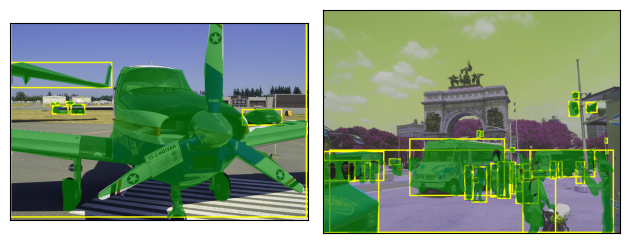

In [7]:
plot([dataset[41], dataset[42]])
print(len(dataset[42][1]["boxes"]))
print(len(dataset[42][1]["masks"]))
print(len(dataset[42][1]["labels"]))

In [7]:
# imgs, annots = next(iter(data_loader))
# plot(imgs[0])
# print(len(annots[0]["masks"]))
# print(len(annots[0]["boxes"]))
# print(len(annots[0]["labels"]))

# print(annots[0]["masks"])

We can see that the color of the images were distorted, zoomed in or out, and flipped.
The bounding boxes and the masks were transformed accordingly. And without any further ado, we can start training.

## Data loading and training loop

Below we're using Mask-RCNN which is an instance segmentation model, but
everything we've covered in this tutorial also applies to object detection and
semantic segmentation tasks.



In [ ]:
import torch
device = torch.device('cpu')

In [ ]:
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    # We need a custom collation function here, since the object detection
    # models expect a sequence of images and target dictionaries. The default
    # collation function tries to torch.stack() the individual elements,
    # which fails in general for object detection, because the number of bounding
    # boxes varies between the images of the same batch.
    collate_fn=lambda batch: tuple(zip(*batch)),
    # shuffle=True
)

model = models.get_model("maskrcnn_resnet50_fpn_v2", weights=None, weights_backbone=None).train()
model.to(device)

count = 0
for imgs, targets in data_loader:
    print(count)

    print(f"{[img.shape for img in imgs] = }")
    print(f"{[(target.keys(), [len(target[key]) for key in target.keys()]) for target in targets] = }")
    
    loss_dict = model(imgs, targets)
    # Put your training logic here

    print(f"Passed sample {count} to model")

    for name, loss_val in loss_dict.items():
        print(f"{name:<20}{loss_val:.3f}")

    count += 1

    print(f"Moving to sample {count}")

0
[img.shape for img in imgs] = [torch.Size([3, 480, 640]), torch.Size([3, 426, 640])]
[(target.keys(), [len(target[key]) for key in target.keys()]) for target in targets] = [(dict_keys(['boxes', 'masks', 'labels']), [8, 8, 8]), (dict_keys(['boxes', 'masks', 'labels']), [2, 2, 2])]
Passed sample 0 to model
loss_classifier     4.486
loss_box_reg        0.037
loss_mask           0.745
loss_objectness     0.695
loss_rpn_box_reg    0.030
Moving to sample 1
1
[img.shape for img in imgs] = [torch.Size([3, 508, 759]), torch.Size([3, 496, 747])]
[(target.keys(), [len(target[key]) for key in target.keys()]) for target in targets] = [(dict_keys(['boxes', 'masks', 'labels']), [2, 2, 2]), (dict_keys(['boxes', 'masks', 'labels']), [1, 1, 1])]
Passed sample 1 to model
loss_classifier     4.476
loss_box_reg        0.001
loss_mask           0.892
loss_objectness     0.695
loss_rpn_box_reg    0.007
Moving to sample 2
2
[img.shape for img in imgs] = [torch.Size([3, 640, 481]), torch.Size([3, 713, 955])]

KeyboardInterrupt: 

## Training References

From there, you can check out the [torchvision references](https://github.com/pytorch/vision/tree/main/references) where you'll find
the actual training scripts we use to train our models.

**Disclaimer** The code in our references is more complex than what you'll
need for your own use-cases: this is because we're supporting different
backends (PIL, tensors, TVTensors) and different transforms namespaces (v1 and
v2). So don't be afraid to simplify and only keep what you need.

